# Horizontal slices

One of the most common operations on a ROMS Dataset is to take a horizontal slice.
Usually at fixed depth, but more general slices are sometimes used.

In [1]:
import matplotlib.pyplot as plt
import xroms
%matplotlib inline

In [2]:
A = xroms.roms_dataset('ocean_avg_0014.nc')

### Surface plots

The simplest is operation is to do a surface plot. 
This is available as the highest `s_rho` value.

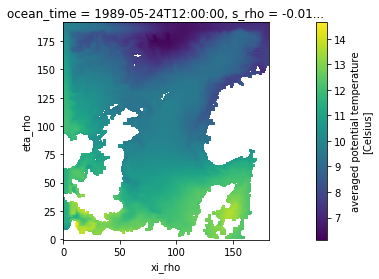

In [3]:
# Plot Sea Surface Temperature
SST = A.temp.isel(ocean_time=0, s_rho=-1)
SST = SST.where(A.mask_rho > 0)

SST.plot()
plt.axis('image');

### Slice at fixed depth

The next step is to make a slice at fixed depth.
The `xroms` package has a function `z_slice` for this purpose.

At depths below the surface it is useful to indicate the position
of land. Here this is done by `pcolormesh` of the land mask.
For solutions involving a coast line, see [geography](geography.ipynb) notebook.

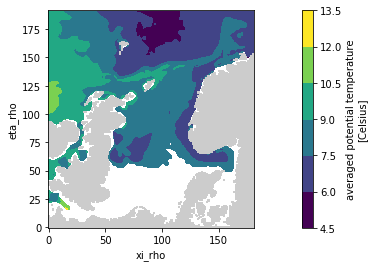

In [4]:
# Temperature at 50 meter at first timeframe
T50 = xroms.zslice(A.temp.isel(ocean_time=0), 50)
# Make a contour plot
T50.plot.contourf()
# Plot the land mask
M = A.mask_rho.where(A.mask_rho < 1)
M.plot(add_colorbar=False, cmap='Pastel2_r')
# Make correct aspect ratio
plt.axis('image');

A useful check is that `z_rho` sliced at a given depth `z`,
should return the depth (really `-abs(z)`),

In [5]:
# Sanity check on zslice
V = xroms.zslice(A.z_rho, 50)
print('Minimum = ', float(V.min()))
print('Maximum = ', float(V.max()))

Minimum =  -50.000003814697266
Maximum =  -49.999996185302734


### Advanced slicing

The `xroms` package can be used to more advanced slicing using the `HorizontalSlicer` class.
An instance can be used as a function, to quickly slice several variables to the same surface.

The `zslice` function is a convenience function for the two-step procedure:

```python
  slicer = xroms.HorizontalSlicer(A.z_rho, -abs(z))
  slicer(A.temp.isel(time=0))
```  

If several variables are needed at the fixed depth, it saves time to make the `slicer` instance
up front.

In [6]:
# Slice at the 35.0 isohaline at first time step
s35_slicer = xroms.HorizontalSlicer(A.salt.isel(ocean_time=0), 35.0)

Plot the depth of the 35.0 isohaline on the left and the Sea Surface Salinity at the right.
The 35.0 isohaline is marked as a black contour line in the right panel.

The white areas in the left panel is where the salinity is nowhere 35.0 in the water column.
In the southern North Sea and along the Norwegian coast because it is fresher and 
in the deeper ocean because it is saltier. 
The green parts with a shallow isohaline has fresher water at the surface. 
The bluish area has salty water on top and an deep isohaline above fresher water.
The sharp "front" is caused by switching from one type of isohaline to the other.

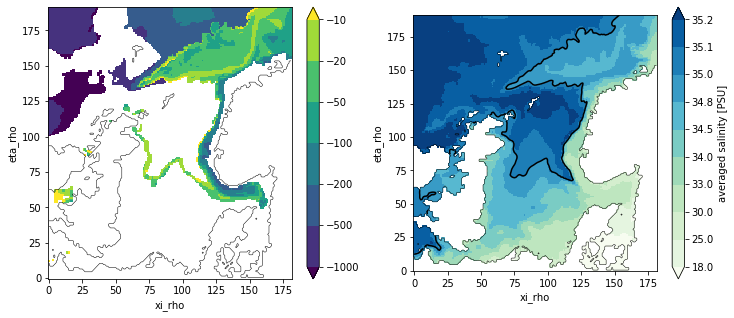

In [7]:
# Compare the depth of the 35.0 isohaline
# with the Sea Surface Salinity

Z = s35_slicer(A.z_rho)             # Depth of isosurface
SSS = A.salt.isel(ocean_time=0, s_rho=-1) # Sea Surface Salinity
SSS = SSS.where(A.mask_rho > 0)     # Mask out land

# Figure with two panels
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Isohaline depth
Z.plot(ax=axes[0], levels=[-1000, -500, -200, -100, -50, -20, -10])
# Make a simple coast line
A.mask_rho.plot.contour(ax=axes[0], levels=[0.5], linewidths=0.5, colors='black')
plt.axis('image');

# Sea Surface salinity
SSS.plot(ax=axes[1], levels=[18, 25, 30, 33, 34, 34.5, 34.8, 35, 35.1, 35.2], cmap='GnBu')
# Emphasize the 35 isohaline
SSS.plot.contour(ax=axes[1], levels=[35], colors='black')
A.mask_rho.plot.contour(ax=axes[1], levels=[0.5], linewidths=0.5, colors='black')
plt.axis('image');

Finally, plot the temperature at the 35 isohaline.
Use only the shallow isohaline, selected by `SSS < 35`

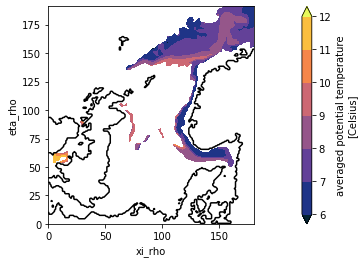

In [8]:
from numpy import arange
import cmocean.cm as cmo   # Import cmocean colourmaps
T = s35_slicer(A.isel(ocean_time=0).temp)
T = T.where(SSS < 35)
T.plot.contourf(levels=arange(6, 13, 1), cmap=cmo.thermal)
A.mask_rho.plot.contour(levels=[0.5], colors='black')
plt.axis('image');

ROMS does not typically store the density. Using the equation of state,
f.ex. from the seawater package, https://github.com/bjornaa/seawater,
the density can be calculated. Below this is used to plot the depth of
the 1028 kg/m^3 isopycnal.

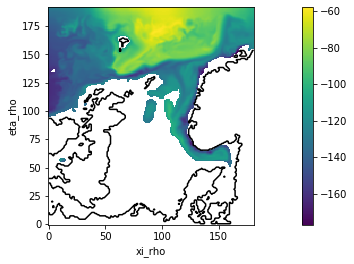

In [9]:
# Could be interesting to continue and plot horizontal
# current vectors at this depth

import seawater as sw

A0 = A.isel(ocean_time=0)
density = sw.dens(A0.salt, A0.temp, -A0.z_rho) 

isopykn = xroms.HorizontalSlicer(density, 1028)
Z = isopykn(A.z_rho)             # Depth of isosurface
Z.plot()
A.mask_rho.plot.contour(levels=[0.5], colors='black')
plt.axis('image');

### Horizontal computations

The XROMS package can also be used to quantify properties in the 
horizontal maps. First make a DataArray of the grid cell areas,
and thereafte sum grid cells with different properties.

In [10]:
# Make a DataArray of the grid cell areas
area = 0.001/A.pm * 0.001/A.pn
area.attrs = dict(long_name='grid cell area', units='km^2')

In [11]:
# Physical sizes
sea_area = area.where(A.mask_rho > 0).sum()
land_area = area.where(A.mask_rho < 1).sum()

#H = A.h.where(A.mask_rho > 0)   # Bathymetry at sea
# area50 = area.where(H < 50).sum()
area50 = area.where((A.mask_rho > 0) & (A.h < 50)).sum()
area50plus = area.where(A.h >= 50).sum()

print(f"Total area                   = {float(area.sum()):10.2f} km²")
print(f"Sea area                     = {float(sea_area):10.2f} km²")
print(f"Land area                    = {float(land_area):10.2f} km²")
print(f"Sea area shallower than 50 m = {float(area50):10.2f} km²")
print(f"Sea area deeper than 50 m    = {float(area50plus):10.2f} km²")

Total area                   = 2340062.86 km²
Sea area                     = 1699476.93 km²
Land area                    =  640585.93 km²
Sea area shallower than 50 m =  392411.48 km²
Sea area deeper than 50 m    = 1307065.45 km²


Extract and plot time series related to the seasonal warming
of the Sea Surface Temperature. Two correlated series are considered,
the mean SST and the area with SST > 10°C.

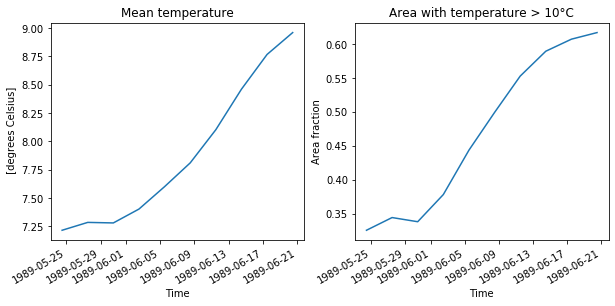

In [12]:
# Sea Surface Temperature
SST = A.temp.isel(s_rho=-1)

# Area weighted spatial mean SST
SSTmean = (SST * area).sum(('xi_rho', 'eta_rho')) / area.sum()  
SSTmean.attrs = dict(units='degrees Celsius')

# Area fraction with SST higher than 10 degrees
A10 = area.where(SST > 10).sum(('xi_rho', 'eta_rho')) / area.sum()
A10.attrs = dict(long_name='Area fraction')

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

SSTmean.plot(ax=axes[0])
axes[0].set_title('Mean temperature')
axes[0].set_xlabel('Time')

A10.plot(ax=axes[1])
axes[1].set_title('Area with temperature > 10°C')
axes[1].set_xlabel('Time');